# Continuous Wavelet Transformation

Continous Wavelet Transformation is an advanced signal processing technique that convert the seismic data from time domain to frequency domain and spectrally decompose the data into each band of frequency

Several steps are performed as below:

* Libraries Importation
* Seismic Data Loading
* Extraction of seismic traces at well location on the base of inline and crossline position.
* Continuous Wavelet Transformation of seismic trace of each well


### Importing Libraries

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cwt3
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from segysak.segy import segy_loader,segy_header_scan
pd.set_option("Display.max_rows",1000)
from cwt3 import ComplexMorletCWT
from scipy.interpolate import interp1d
from segysak import open_seisnc, segy
import glob
import os
import seaborn as sns
from segysak.segy import segy_loader,segy_writer

#### Loading Seismic Data

In [7]:
amplitude1 = segy_loader(r"E:\HighFreq-ML\Zamzama\SEGY\crop-PSTM-Complete-ML.sgy",iline=189,xline=21)

  0%|          | 0.00/420k [00:00<?, ? traces/s]

Loading as 3D
Fast direction is INLINE_3D


Converting SEGY:   0%|          | 0.00/420k [00:00<?, ? traces/s]

#### Extracting seismic trace from well location

In [19]:
NEW_SPECS=amplitude1.sel(iline=[646,332,537,430,571,401,447,489,614])

In [20]:
IL = [646,332,537,430,571,401,447,489,614]
XL = [172,215,199,152,193,205,212,202,163]

In [22]:
data1 = NEW_SPECS.to_dataframe().reset_index()
data1 = data1[(data1["twt"]>=2000)&(data1["twt"]<=2500)]
data1 = data1[data1["data"]!=0]
data1

,iline,xline,twt,data
18507,646,9,2000.0,4681.726562
18508,646,9,2002.0,5618.691406
18509,646,9,2004.0,5947.250000
18510,646,9,2006.0,5870.710938
18511,646,9,2008.0,5671.054688
...,...,...,...,...
7811869,614,341,2492.0,-3876.802734
7811870,614,341,2494.0,-5162.765625
7811871,614,341,2496.0,-6171.039062
7811872,614,341,2498.0,-6866.562500


#### Continuous Wavelet Transformation of seismic trace of each well

In [122]:
paths_new = glob.glob(os.path.join(r"E:\HighFreq-ML\Zamzama\Synthetic-1","*.csv"))
paths_new

['E:\\HighFreq-ML\\Zamzama\\Synthetic-1\\_1.csv',
 'E:\\HighFreq-ML\\Zamzama\\Synthetic-1\\_2.csv',
 'E:\\HighFreq-ML\\Zamzama\\Synthetic-1\\_3.csv',
 'E:\\HighFreq-ML\\Zamzama\\Synthetic-1\\_4.csv',
 'E:\\HighFreq-ML\\Zamzama\\Synthetic-1\\_5.csv',
 'E:\\HighFreq-ML\\Zamzama\\Synthetic-1\\_6.csv',
 'E:\\HighFreq-ML\\Zamzama\\Synthetic-1\\_7.csv',
 'E:\\HighFreq-ML\\Zamzama\\Synthetic-1\\_8.csv',
 'E:\\HighFreq-ML\\Zamzama\\Synthetic-1\\_9.csv']

In [72]:
data2 = pd.read_csv(paths_new[0])
data = data1[(data1["iline"]==IL[0])&(data1["xline"]==XL[0])].reset_index(drop=True)
amplitude = data["data"].values
fs = 200
n_samples = amplitude.size
time_axis = np.arange(0, n_samples) / fs

In [73]:
lower_freq = 3
upper_freq = 24
n_scales = 100
wavelet_width = 1

In [74]:
cwt = ComplexMorletCWT(wavelet_width, fs, lower_freq, upper_freq, n_scales)

In [75]:
which_scale = -1

In [76]:
real_bank = cwt.real_part
imag_bank = cwt.imaginary_part
single_real_wavelet = real_bank[0, :, 0, which_scale]
single_imag_wavelet = imag_bank[0, :, 0, which_scale]

In [77]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    np_single_real_wavelet, np_single_imag_wavelet = sess.run([single_real_wavelet, single_imag_wavelet])
single_wavelet_size = np_single_real_wavelet.size
time_axis = np.arange(0, single_wavelet_size) / fs
time_axis = time_axis - np.mean(time_axis)
prepared_signal = amplitude.reshape((1, -1, 1)).astype(np.float32)
scalogram = cwt(prepared_signal)

In [78]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())  # In case it wasn't run before
    np_scalogram = sess.run(scalogram)
print("The result has shape", np_scalogram.shape)
scalogram_real = np_scalogram[0, :, :, 0]
scalogram_imag = np_scalogram[0, :, :, 1]
scalogram_magn = np.sqrt(scalogram_real ** 2 + scalogram_imag ** 2)

The result has shape (1, 251, 100, 2)


In [80]:
sample = data2.copy()
sample["DPTM"] = sample["DPTM"]*1000
imaginary = pd.DataFrame(scalogram_imag)
imaginary = pd.concat([imaginary,data["twt"]],axis=1)
imaginary = imaginary[(imaginary["twt"]>sample["DPTM"].min()+1)&(imaginary["twt"]<sample["DPTM"].max()-1)]
real = pd.DataFrame(scalogram_real)
real = pd.concat([real,data["twt"]],axis=1)
real = real[(real["twt"]>sample["DPTM"].min()+1)&(real["twt"]<sample["DPTM"].max()-1)]
magnitude = pd.DataFrame(scalogram_magn)
magnitude = pd.concat([magnitude,data["twt"]],axis=1)
magnitude = magnitude[(magnitude["twt"]>sample["DPTM"].min()+1)&(magnitude["twt"]<sample["DPTM"].max()-1)]
wave = [imaginary,magnitude,real]

In [86]:
sample = data2.copy()
imaginary = pd.DataFrame(scalogram_imag)
imaginary = pd.concat([imaginary,data["twt"]],axis=1)
imaginary = imaginary[(imaginary["twt"]>sample["DPTM"].min()*1000-2)&(imaginary["twt"]<sample["DPTM"].max()*1000+2)]
real = pd.DataFrame(scalogram_real)
real = pd.concat([real,data["twt"]],axis=1)
real = real[(real["twt"]>sample["DPTM"].min()*1000-2)&(real["twt"]<sample["DPTM"].max()*1000+2)]
magnitude = pd.DataFrame(scalogram_magn)
magnitude = pd.concat([magnitude,data["twt"]],axis=1)
magnitude = magnitude[(magnitude["twt"]>sample["DPTM"].min()*1000-2)&(magnitude["twt"]<sample["DPTM"].max()*1000+2)]

In [91]:
wave = [imaginary,magnitude,real]
sign = ["I","M","R"]
for i in range(len(wave)):
    for j in wave[i].columns[:100]:
        f = interp1d(wave[0]["twt"],wave[i][j],fill_value='extrapolate')
        sample[f"{sign[i]+str(j)}"] = f(sample["DPTM"])

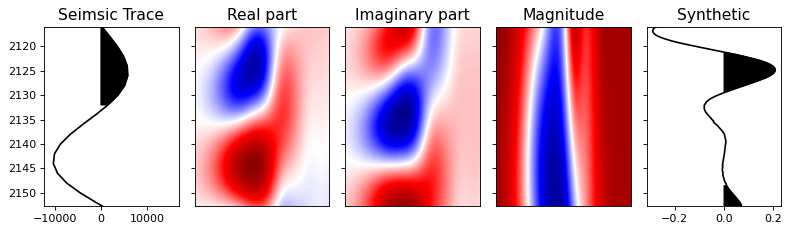

In [121]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3), dpi=80, sharey=True)
axes[0].plot(amplitude,data["twt"],color="black")
axes[0].fill_betweenx(data["twt"], 0.2 , amplitude, where=(amplitude>0.5),color='k')
axes[0].set_title("Seimsic Trace",fontsize=14)
axes[0].set_ylim(1900,2500)
axes[1].invert_yaxis()
axes[1].imshow(scalogram_real, interpolation="spline36", aspect="auto", extent=[0, scalogram_real.shape[0], data["twt"].max(), data["twt"].min()],cmap="seismic_r")
axes[1].set_title("Real part",fontsize=14)


axes[2].imshow(scalogram_imag, interpolation="spline36", aspect="auto", extent=[0, scalogram_imag.shape[0],data["twt"].max(), data["twt"].min()],cmap="seismic_r")
axes[2].set_title("Imaginary part",fontsize=14)


axes[3].imshow(scalogram_magn, interpolation="spline36", aspect="auto", extent=[0, scalogram_magn.shape[0], data["twt"].max(), data["twt"].min()],cmap="seismic_r")
axes[3].set_title("Magnitude",fontsize=14)

axes[4].plot(sample["Synthetic"],sample["DPTM"]*1000,color="black")

axes[4].fill_betweenx(sample["DPTM"]*1000, 0 , sample["Synthetic"], where=(sample["Synthetic"]>0.01),color='k')

axes[0].set_ylim([sample["DPTM"].max()*1000, sample["DPTM"].min()*1000])
axes[4].set_title("Synthetic",fontsize=14)
plt.tight_layout()
axes[1].set_xticks([])
axes[2].set_xticks([])
axes[3].set_xticks([])

plt.show()

In [123]:
sample.to_csv(f"E:\HighFreq-ML\Zamzama\CWT_data\\_1.csv",index=False)